# [E-09] 폐렴 진단하기

|평가문항|상세기준|
|:---|:---|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

In [31]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.merge import Concatenate
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline


In [32]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [224, 224] 
# 최종적인 모델은 vgg16의 가중치들로 초기화 시켜주는 pretained 모델을 사용할 것이기 때문에 이미지 사이즈 224로 사용해야함.

# train_datagen = ImageDataGenerator(rescale=1./255)
# val_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

#pretained model
# VGG_PATH = ROOT_PATH + '/pretained/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [33]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [34]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(10)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [35]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person351_bacteria_1617.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person313_bacteria_1457.jpeg


In [36]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1089
Pneumonia images count in training set: 3096


In [37]:
#
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [38]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [39]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [40]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [41]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [42]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  True


In [43]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [44]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

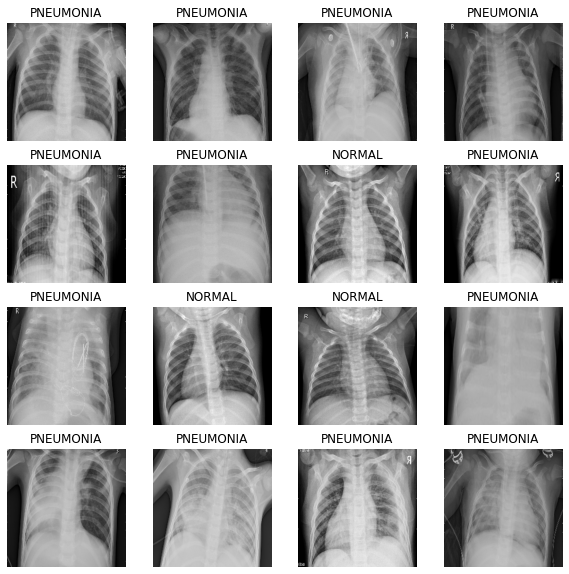

In [45]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [20]:
#CNN
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [21]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

Batch Normalization과 Dropout은 서로 어울리는지에 대한 염두를 두고 프로젝트를 진행하고 결과를 살펴보자.

참고 문헌에 각 입장에 대한 논문 2편도 있다.

### 모델 설계-1

In [28]:
# def build_model():
#     model = tf.keras.Sequential([
#         tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
#         tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
#         tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
#         tf.keras.layers.MaxPool2D(),
        
#         conv_block(32),
#         conv_block(64),
        
#         conv_block(128),
#         tf.keras.layers.Dropout(0.2),
        
#         conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
#         tf.keras.layers.Flatten(),
#         dense_block(512, 0.7),
#         dense_block(128, 0.5),
#         dense_block(64, 0.3),
        
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])
    
#     return model

### 모델 설계-2

- 이미지넷을 통해 pretained된 VGG16의 Weights들로 처음 두 convolution layer들을 초기화 시켜줄 것이다.
- VGG16은 Input 사이즈가 224*224로 고정되어 있기 때문에 사이즈 수정.
- Depthwise Separable Convolution은 파라미터를 줄일 수 있다는 장점 일 이용하여 더 깊은 모델로 구성.

In [47]:
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import EarlyStopping


pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
pre_trained_vgg.trainable = False
pre_trained_vgg.summary()
 


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [50]:
additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4096, activation='relu'))
additional_model.add(layers.Dense(2048, activation='relu'))
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(1, activation='softmax'))
 
 
additional_model.summary()
 
 
checkpoint = ModelCheckpoint(filepath='pretrained_VGG_weight.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)
 
with tf.device('/GPU:0'):

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    additional_model.compile(
        loss='categorical_crossentropy', 
        optimizer=keras.optimizers.RMSprop(lr=2e-5), 
        metrics=METRICS
    )
 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 4096)              102764544 
_________________________________________________________________
dense_29 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dense_30 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 1025      
Total params: 127,969,089
Trainable params: 113,254,401
Non-trainable params: 14,714,688
_______________________________

Imbalanced data를 해결해주기 위해 class별로 가중치에 변화를 주었음.

In [55]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.92
Weight for PNEUMONIA: 0.68


### <span style="color:blue"> - 모델(1) 결과- </span>
모델(1) 종료 까지 Run x

In [31]:
"""좌우 반전 augmentation/ class_weight 설정/ sample 모델로 training"""
# with tf.device('/GPU:0'):
#     history = model.fit(
#         train_ds,
#         steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
#         epochs=EPOCHS,
#         validation_data=val_ds,
#         validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#         class_weight=class_weight,
#     )

Epoch 1/25
261/261 [==============================] - 62s 189ms/step - loss: 0.3958 - accuracy: 0.7991 - precision: 0.9392 - recall: 0.7805 - val_loss: 0.6360 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 190ms/step - loss: 0.2249 - accuracy: 0.9181 - precision: 0.9769 - recall: 0.9115 - val_loss: 1.1593 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 191ms/step - loss: 0.2000 - accuracy: 0.9289 - precision: 0.9759 - recall: 0.9272 - val_loss: 0.6649 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1914 - accuracy: 0.9294 - precision: 0.9783 - recall: 0.9257 - val_loss: 0.1447 - val_accuracy: 0.9462 - val_precision: 0.9931 - val_recall: 0.9334
Epoch 5/25
261/261 [==============================] - 52s 199ms/step - loss: 0.1944 - accura

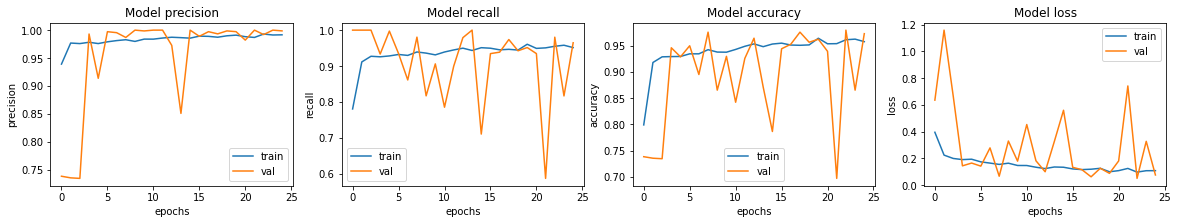

In [32]:
# fig, ax = plt.subplots(1, 4, figsize=(20, 3))
# ax = ax.ravel()

# for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
#     ax[i].plot(history.history[met])
#     ax[i].plot(history.history['val_' + met])
#     ax[i].set_title('Model {}'.format(met))
#     ax[i].set_xlabel('epochs')
#     ax[i].set_ylabel(met)
#     ax[i].legend(['train', 'val'])

In [33]:
# loss, accuracy, precision, recall = model.evaluate(test_ds)
# print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

# # 좌우 반전 Augmentation이 추가된 결과

39/39 [==============================] - 4s 110ms/step - loss: 0.7146 - accuracy: 0.8205 - precision: 0.7825 - recall: 0.9872
Loss: 0.7146101593971252,
Accuracy: 0.8205128312110901,
Precision: 0.7825203537940979,
Recall: 0.9871794581413269


### <span style="color:blue"> - 모델(1) 종료- </span>

### Augmentation 적용 전의 결과값
39/39 [==============================] - 4s 107ms/step - loss: 1.1029 - accuracy: 0.8189 - precision: 0.7798 - recall: 0.9897

Loss: 1.102857232093811,

**Accuracy: 0.8189102411270142,**

**Precision: 0.7797979712486267,**

**Recall: 0.9897435903549194**


In [51]:
with tf.device('/GPU:0'):
    history = additional_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=50,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        callbacks=[es, checkpoint],
        class_weight=class_weight,
    )
    

Epoch 1/50
261/261 [==============================] - 60s 196ms/step - loss: 0.0000e+00 - accuracy: 0.7397 - precision: 0.7397 - recall: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.7500 - val_precision: 0.7500 - val_recall: 1.0000
Epoch 2/50
261/261 [==============================] - 52s 198ms/step - loss: 0.0000e+00 - accuracy: 0.7392 - precision: 0.7392 - recall: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.7510 - val_precision: 0.7510 - val_recall: 1.0000
Epoch 3/50
261/261 [==============================] - 51s 196ms/step - loss: 0.0000e+00 - accuracy: 0.7407 - precision: 0.7407 - recall: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.7529 - val_precision: 0.7529 - val_recall: 1.0000
Epoch 4/50
261/261 [==============================] - 51s 196ms/step - loss: 0.0000e+00 - accuracy: 0.7399 - precision: 0.7399 - recall: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.7519 - val_precision: 0.7519 - val_recall: 1.0000
Epoch 5/50
261/261 [==============================] - 52s 20

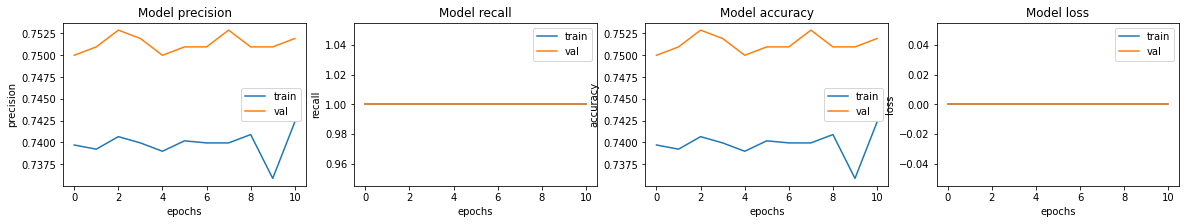

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [54]:
loss, accuracy, precision, recall = additional_model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

# pretained vgg16 

39/39 [==============================] - 5s 119ms/step - loss: 0.0000e+00 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.0,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


## 참고문헌

1. <Batch Normalization과 Dropout은 서로 어울리는가?> 에 대한 각 입장에 대한 논문 2편

- https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf

- https://arxiv.org/pdf/1905.05928.pdf

2. 딥러닝에서 클래스 불균형을 다루는 방법, Deep Play블로그 : https://3months.tistory.com/414

3. Beating everything with Depthwise Convolution, Kaggle : https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution
4. [딥러닝] Depth-wise Separable Convolution 원리(Pytorch 구현), <코딩이 재밌다!> 블로그 : https://coding-yoon.tistory.com/122

aug x, classweight, sample model - aug o, classweight, smaple model - aug o, pretained weights+ deeper model - aug more, no dropout